In [1]:
import yfinance as yf
import bs4 as bs
import pickle
import requests
import pandas as pd
import json
from dateutil import parser
from datetime import datetime
import os
import time
from pandas.io.json import json_normalize
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
import wrds
from datetime import datetime as dt
import numpy as np
import glob, os
import csv
from matplotlib import pyplot as plt
import os.path
from os import path

import yakPak as yP

In [2]:
pd.set_option("display.precision", 8)
%load_ext autoreload
%autoreload 2

In [3]:
# Define start and end of download
# allows for rolling windows
start_download = '2006-04-02'#pd.to_datetime('2009-04-02' , format = '%Y-%m-%d')
end_download = '2020-06-15'#pd.to_datetime('2020-06-15', format = '%Y-%m-%d')

In [4]:
start_date = '2009-06-30'#pd.to_datetime('2009-06-02', format = '%Y-%m-%d') # Define start and end dates
end_date = '2020-02-03'#pd.to_datetime('2020-04-15', format = '%Y-%m-%d')

In [5]:
changes = pd.read_csv('S&P 500 Historical Components & Changes(10-14-2022).csv',
                              header=0,
                              index_col=0,
                              parse_dates=True)

In [42]:
tickers = sorted(set.intersection(*list(changes[start_date:end_date].apply(lambda x: set(x.dropna()), axis=1))))

In [7]:

    
if not path.exists("Export\OHLC_data"):
    data_yf = yf.download(tickers, start=start_download, end=end_download)

    with open('Export/OHLC_data', 'wb') as fh:
        pickle.dump(data_yf, fh)
    
    print('\n dumped \'data_yf\' to pickle as OHLC')
    
elif path.exists("Export\OHLC_data"):
    # load from pickle
    with open("Export\OHLC_data","rb") as fin:
        data_yf = pickle.load(fin)
    #data_yf.index = pd.to_datetime(data_yf.index, format = '%Y-%m-%d)     
    print('loaded OHLC data from pickle as \'data_yf\'')


loaded OHLC data from pickle as 'data_yf'


In [8]:
ac = data_yf['Adj Close']
ac.index = pd.to_datetime(ac.index, format = '%Y-%m-%d')

#oco = (data_yf['Close'] - data_yf['Open'])/data_yf['Open']

In [9]:
ac.index.dtype

dtype('<M8[ns]')

In [10]:
ac = ac.dropna(axis=0, how='all')
ac = ac.dropna(axis=1)

## Rolling Window Calcs

In [11]:
#ac = ac.resample('MS').ffill().dropna()

In [12]:
ac_rolling = ac.rolling(12)

In [13]:
ac_mean = ac_rolling.mean()
ac_std = ac_rolling.std()

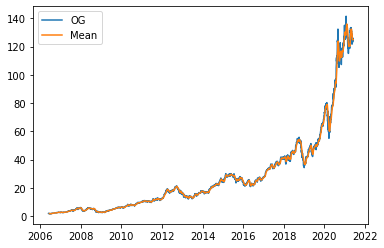

In [14]:
plt.plot(ac['AAPL'], label = 'OG')
plt.plot(ac_mean['AAPL'], label = 'Mean')
plt.legend();

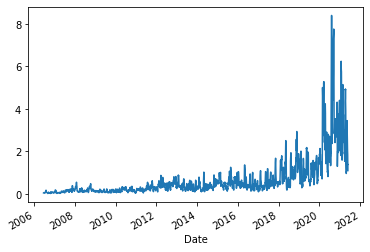

In [15]:
ac_std['AAPL'].plot();

## Augmented Dickey Fuller Test 

In [16]:
# determines if time series is stationary or non-stationary
from statsmodels.tsa.stattools import adfuller

In [17]:
adf_results = adfuller(ac['AAPL'])
print('ADF Stats: ', adf_results[0])
print('p-value: ', adf_results[1])

critical_values = adf_results[4]
for key, value in critical_values.items():
    print('Critical Value (%s): %.3f' % (key, value))
    

ADF Stats:  2.467901203269117
p-value:  0.9990387629702224
Critical Value (1%): -3.432
Critical Value (5%): -2.862
Critical Value (10%): -2.567


## Detrending

In [18]:
#ac = data_yf['Adj Close']

In [19]:
ac_log = np.log(ac)

In [20]:
ac_log_ma = ac_log.rolling(2).mean()

In [21]:
ac_detrend = ac_log - ac_log_ma
ac_detrend.dropna(inplace = True)

In [22]:
#mean and std of detrended data
ac_detrend_rolling = ac_detrend.rolling(12)
ac_detrend_ma = ac_detrend_rolling.mean()
ac_detrend_std = ac_detrend_rolling.std()

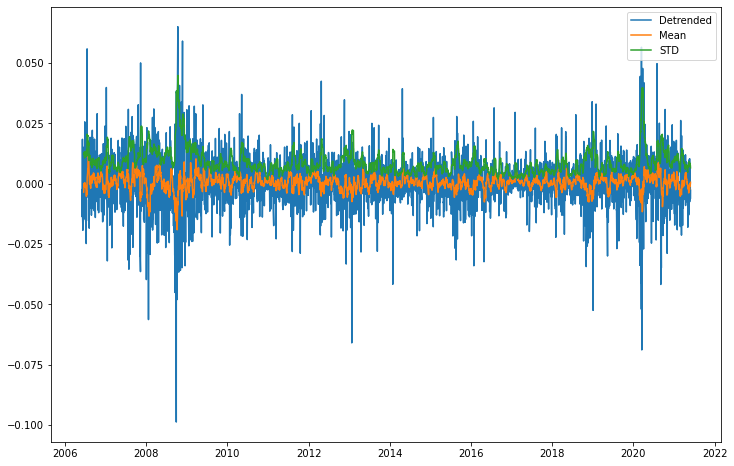

In [23]:
plt.figure(figsize=(12,8))
plt.plot(ac_detrend['AAPL'], label = 'Detrended')
plt.plot(ac_detrend_ma['AAPL'], label = 'Mean')
plt.plot(ac_detrend_std['AAPL'], label = 'STD')
plt.legend(loc = 'upper right');

In [24]:
adf_results = adfuller(ac_detrend['AAPL'])
print('ADF Stats: ', adf_results[0])
print('p-value: ', adf_results[1])

critical_values = adf_results[4]
for key, value in critical_values.items():
    print('Critical Value (%s): %.3f' % (key, value))

ADF Stats:  -14.217159225283718
p-value:  1.682075496196361e-26
Critical Value (1%): -3.432
Critical Value (5%): -2.862
Critical Value (10%): -2.567


In [25]:
ac_detrend = ac_detrend[start_date:end_date]

In [26]:
#export detrended adjClose
ac_detrend.T.to_csv('Export/ac_detrend.csv') 

In [27]:
ac_detrend[start_date:end_date]

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WY,WYNN,XEL,XOM,XRAY,XRX,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2009-06-30,-0.00294540,0.00161747,-0.00921539,-0.00822292,-0.00562201,0.00202187,-0.00888594,0.00212059,-0.01453896,-0.00100373,...,-0.00329239,-0.00278538,-0.02257063,-0.00081410,-0.00476907,-0.00520657,-0.01068726,0.00029990,-0.00455687,-0.02857900
2009-07-01,0.00757386,0.00140224,0.01389771,-0.00426996,0.00632032,0.00161148,0.01436036,-0.00127148,-0.00850179,0.00994465,...,-0.00072318,0.00555552,0.00127313,0.00994934,0.00462735,-0.00147433,0.00993139,0.02458061,-0.00864208,-0.00916666
2009-07-02,-0.02231396,-0.00993478,-0.01164791,-0.00387437,-0.01811922,-0.00322823,-0.01867469,-0.01682872,-0.01495894,-0.02338191,...,-0.00603141,-0.02090545,-0.02878691,-0.01267289,-0.01488777,-0.01061027,-0.01614296,-0.01111627,-0.02010279,-0.01294133
2009-07-06,-0.00432905,-0.00506058,-0.00084266,-0.00303411,-0.00875934,-0.01271081,0.00394058,0.00131477,0.00165379,0.00288077,...,-0.00062822,0.00806741,-0.01089317,0.00651155,-0.00285526,-0.00657790,-0.00946386,0.00868322,0.00062094,0.00315465
2009-07-07,-0.01453138,-0.01171542,0.01139252,-0.00722588,-0.01532830,-0.00584808,0.00889268,-0.01390621,-0.01338617,-0.01520637,...,0.00115090,-0.03683612,-0.03058964,-0.01034907,-0.01143676,-0.01202817,-0.01865584,-0.00504665,-0.00649818,-0.00496615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-28,0.00356862,0.01394835,0.00900204,-0.00027911,0.01101923,0.00927087,0.00445960,0.00723090,0.01050810,0.00130911,...,0.00318330,0.00363271,0.00433982,0.00223654,-0.00069560,-0.00547098,0.02408925,0.00205531,0.00390270,0.00673449
2020-01-29,0.00034396,0.01035806,0.00419074,-0.00223865,-0.00420510,-0.00474632,-0.00273960,-0.02078502,-0.00072540,0.00433855,...,-0.00305383,-0.00479422,-0.00450131,0.00148528,-0.00419385,-0.00127107,-0.00068027,0.00856014,0.00516755,-0.00770392
2020-01-30,-0.01666634,-0.00072498,-0.00548286,0.00011225,0.00717119,-0.00381212,0.02369679,0.01147283,-0.00188097,0.00540145,...,0.00296809,-0.00049862,0.01105969,0.00984032,0.00527548,-0.01115352,0.00339172,-0.00014066,0.00142417,0.00418767


## Differencing

In [28]:
ac_log_diff = ac_log.diff(periods=3).dropna()

In [29]:
ac_diff_rolling = ac_log_diff.rolling(12)
ac_diff_ma = ac_diff_rolling.mean()
ac_diff_std = ac_diff_rolling.std()

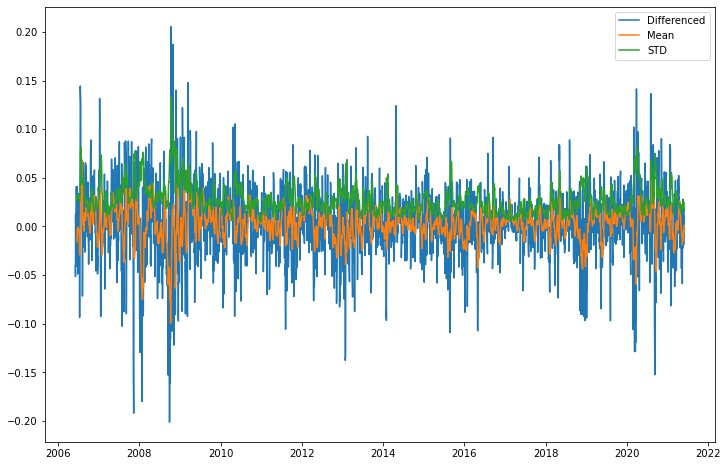

In [30]:
plt.figure(figsize=(12,8))
plt.plot(ac_log_diff['AAPL'], label = 'Differenced')
plt.plot(ac_diff_ma['AAPL'], label = 'Mean')
plt.plot(ac_diff_std['AAPL'], label = 'STD')
plt.legend(loc = 'upper right');

In [31]:
ac_log_diff = ac_log_diff[start_date:end_date]

In [32]:
#export detrended adjClose
ac_log_diff.T.to_csv('Export/ac_diff.csv')

In [33]:
ac_log_diff

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WY,WYNN,XEL,XOM,XRAY,XRX,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2009-06-30,0.01738359,0.01820876,-0.02889100,-0.02061915,-0.00774383,-0.00040352,-0.00781390,0.02369858,-0.05633852,0.00201047,...,-0.01455087,-0.00655064,-0.05134956,0.01092287,0.00042904,-0.00976572,-0.01940872,-0.00895799,-0.00748388,-0.05142307
2009-07-01,0.01170728,0.00273421,0.00384557,-0.01679637,0.02329791,0.00322297,0.03171395,0.01884655,-0.05677130,0.03445794,...,-0.00536086,0.02002357,-0.03689239,0.03137113,0.02163245,-0.01465626,-0.00302120,0.05246579,-0.02895295,-0.04732112
2009-07-02,-0.03537099,-0.01383016,-0.01393118,-0.03273450,-0.03484183,0.00081025,-0.02640055,-0.03195925,-0.07599939,-0.02888197,...,-0.02009395,-0.03627062,-0.10016881,-0.00707530,-0.03005899,-0.03458235,-0.03379767,0.02752846,-0.06660348,-0.10137398
2009-07-06,-0.03813828,-0.02718624,0.00281428,-0.02235688,-0.04111648,-0.02865511,-0.00074752,-0.03357087,-0.04361388,-0.02111297,...,-0.01476562,-0.01456506,-0.07681390,0.00757601,-0.02623138,-0.03732500,-0.03135085,0.04429511,-0.05624787,-0.03790666
2009-07-07,-0.08234877,-0.05342156,-0.00219611,-0.02826872,-0.08441371,-0.04357423,-0.01168288,-0.05884031,-0.05338265,-0.07141501,...,-0.01101745,-0.09934833,-0.14053944,-0.03302082,-0.05835960,-0.05843269,-0.08852532,-0.01495941,-0.05196009,-0.02950564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-28,-0.02144753,-0.00483576,-0.02274473,-0.01320275,0.00812585,-0.05571889,-0.02362591,0.00263930,0.00717457,0.00024923,...,0.00679829,-0.01405023,-0.10719126,0.00477190,-0.03226584,-0.00976927,0.01506681,-0.01100598,-0.00207548,-0.01475599
2020-01-29,-0.01162403,0.01876665,0.01051591,-0.01403619,0.00082502,-0.03761267,-0.01409425,-0.03543799,0.00275739,0.00780606,...,0.01320269,-0.01418465,-0.08435012,0.00371483,-0.03389114,-0.01231142,0.03349781,0.01559485,0.01976279,-0.00559144
2020-01-30,-0.02550753,0.04716285,0.01541985,-0.00481101,0.02797066,0.00142484,0.05083358,-0.00416257,0.01580345,0.02209821,...,0.00619514,-0.00332027,0.02179641,0.02712428,0.00077206,-0.03579114,0.05360140,0.02094957,0.02098884,0.00643649


## Seasonal Decomposition

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [35]:
ac_log

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WMT,WY,WYNN,XEL,XOM,XRAY,XRX,YUM,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2006-06-01,3.06524724,0.63798981,2.83505056,2.64475846,3.35759372,3.12163318,3.37715873,3.19215933,3.62593969,3.21660916,...,3.52170486,2.62702893,3.69279738,2.33255798,3.54618230,3.32145406,3.18177552,2.59370575,3.99082443,4.15223292
2006-06-02,3.07913834,0.62975248,2.83253803,2.64267359,3.36729583,3.13008922,3.35635623,3.18540627,3.59813381,3.22794937,...,3.51006435,2.61620796,3.66986241,2.33571972,3.55497971,3.33033254,3.16969709,2.59311616,3.99360595,4.15913137
2006-06-05,3.04535333,0.60246158,2.81523915,2.62701755,3.38337277,3.08312649,3.33631795,3.17772635,3.55905550,3.22945082,...,3.49659379,2.58463002,3.64119317,2.32514311,3.52868400,3.31003826,3.15457238,2.57546571,3.99180703,4.14540939
2006-06-06,3.03657838,0.59778405,2.82496356,2.62158591,3.39584978,3.07702158,3.34447687,3.18431272,3.56331620,3.23144919,...,3.49319764,2.56927320,3.63218131,2.32726747,3.53449562,3.30014869,3.15166561,2.58680569,4.01109613,4.14931466
2006-06-07,3.03245726,0.57816909,2.82127030,2.63709417,3.36106958,3.06407829,3.33800243,3.18442265,3.56047775,3.22704753,...,3.49340974,2.55268481,3.65098467,2.33097391,3.50798849,3.31755453,3.13847849,2.60736411,4.02623250,4.15174739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,4.88396046,4.83623165,4.75526994,4.74035498,6.21025863,5.06416671,4.16873980,5.25568828,5.66115333,4.40022298,...,4.93460983,3.53739026,4.86337200,4.23112527,4.02054789,4.19858277,3.09482908,4.76550731,5.08221635,4.01241764
2021-05-25,4.88313513,4.83465680,4.72503351,4.74977421,6.22471681,5.07158471,4.16828938,5.24630617,5.66805167,4.38905762,...,4.93869280,3.54034702,4.86004493,4.22510746,3.99764024,4.19041947,3.07367760,4.76617085,5.08162033,3.98581984
2021-05-26,4.88358525,4.83426274,4.72233400,4.73574038,6.22847158,5.07256163,4.16678646,5.24209653,5.67849889,4.39168198,...,4.93749784,3.55816892,4.88620519,4.22173301,4.00924439,4.18743444,3.08895155,4.76525836,5.06004937,3.99823794


In [36]:
ac_residual = ac_log.apply(lambda x: seasonal_decompose(x, model = 'additive', period = 12).resid, axis = 0).dropna()


In [37]:
ac_residual = ac_residual[start_date:end_date]

In [38]:
#export detrended adjClose
ac_residual.T.to_csv('Export/ac_resid.csv')

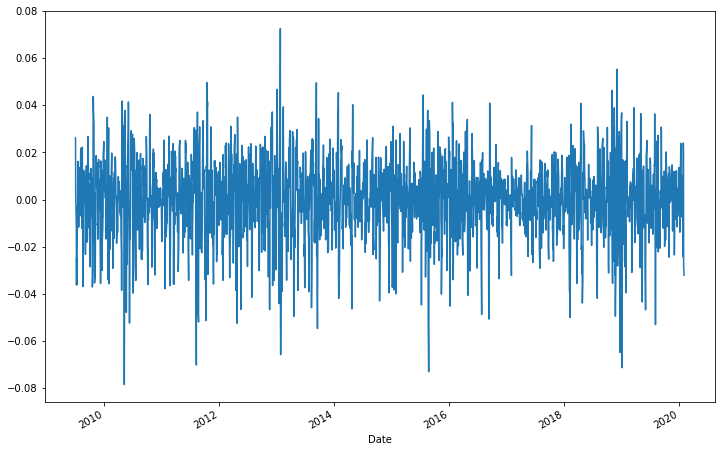

In [39]:
plt.rcParams['figure.figsize'] = (12,8)
fig = ac_residual['AAPL'].plot()

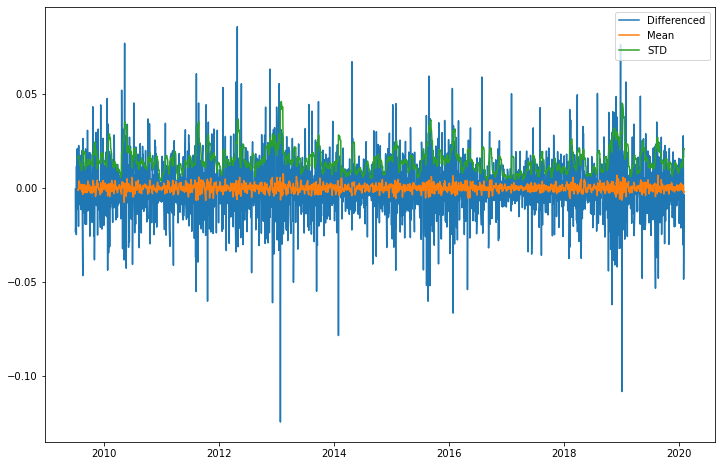

In [41]:
ac_log_diff = ac_residual.diff().dropna()

#mean and std of differenced data
ac_diff_rolling = ac_log_diff.rolling(12)
ac_diff_ma = ac_diff_rolling.mean()
ac_diff_std = ac_diff_rolling.std()

# plot the stationary data
plt.figure(figsize=(12,8))
plt.plot(ac_log_diff['AAPL'], label = 'Differenced')
plt.plot(ac_diff_ma['AAPL'], label = 'Mean')
plt.plot(ac_diff_std['AAPL'], label = 'STD')
plt.legend(loc = 'upper right');